In [10]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim


transform = transforms.ToTensor() #Definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

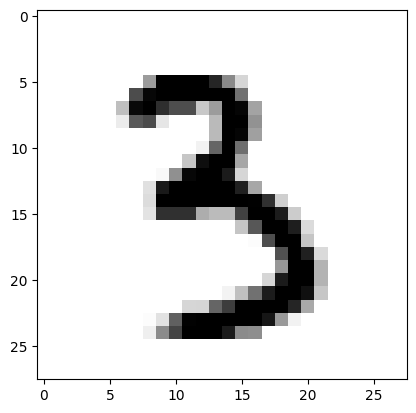

In [11]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter) # Use next(dataiter) ao em vez de dataiter.next() para evitar erro
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [12]:
print(imagens[0].shape) # Para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # Para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [13]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # Camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # Camada de entrada 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # Camada de entrada 2, 64 neurônios que se ligam a 10
        # Para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2
        
    def forward(self, X):
        X = F.relu(self.linear1(X)) # Função da ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # Função da ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # Função da ativação da camada interna 2 para a camada de saída, nesse caso f(x) = X
        return F.log_softmax(X, dim=1) # Dados utilizados para calcular a perda

In [14]:
def treino(modelo, trainloader, device):
        
    otimizador = optim.SGD(modelo.paramenters(), lr=0.01, momentum=0.5) # Define a política de atualização dos pesos da bias
    inicio = time() # Timer para sabermos quanto tempo levou o treino
    
    criterio = nn.NLLLoss() # Definindo o critério par calcular a perda
    EPOCHS = 10 # Número de ephocs que o algoritmo rodará
    modelo.train() # Ativando o modo de treino do modelo
    
    for epoch in range(EPOCHS):
        perda_acumulada = 0 # Inicialização da perda acumulada da epoch em questão
        
        for imagens, etiquetas in trainloader:
            
            imagens = imagens.view(imagens.shape[0],-1) # Convertendo as imagens para "vetores" de 28*28 casas para ficarem compatíveis com a
            otimizador.zero_grad() # Zerando os gradientes por conta do ciclo anterior
            
            output = modelo(imagens.to(device)) # Colocando os dados no modelo
            perda_instatanea = criterio(output, etiquetas.to(device)) # Calculando a perda da epoch em questão
            
            perda_instatanea.backward() # Back propagation a partir da perda
            
            otimizador.step() # Atualizando os pesos e as bias
            
            perda_acumulada += perda_instatanea.item() # Atualizando a perda acumulada
            
    else:
        print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) =", (time()-inicio)/60)

In [15]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0,0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1,784)
            # Desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # Output do modelo em escala logaritmica
                
            ps = torch.exp(logps) # Converte output para escala normal (lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # Converte o tensor em um número, no caso, o número que o modelo previu como correto
            etiqueta_certa = etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred): # Compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas += 1
        
        print("Total de imagens testadas =", conta_todas)
        print("\nPrecisão do modelo = {}%",format(conta_corretas*100/conta_todas))

In [16]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)